# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14820457.93it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 283546.92it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4918510.75it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4584347.56it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [3]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


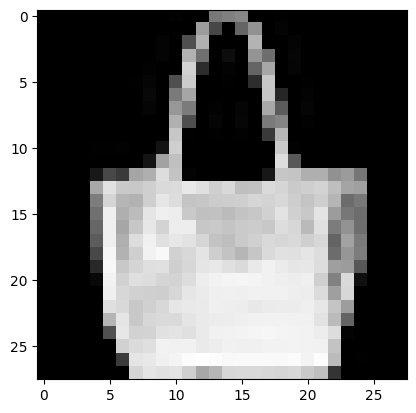

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [5]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Conv2d(1,3, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Flatten(),
                      nn.Linear(14*14*3, 256),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    # images = images.view(images.shape[0], -1)

    # Training pass
    optimizer.zero_grad()

    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()

      # Validation pass
      for images, labels in testloader:
        log_ps = model(images)

        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.786.. Test loss: 0.504.. Test Accuracy: 0.807
Epoch: 2/30.. Training loss: 0.537.. Test loss: 0.402.. Test Accuracy: 0.857
Epoch: 3/30.. Training loss: 0.476.. Test loss: 0.369.. Test Accuracy: 0.870
Epoch: 4/30.. Training loss: 0.443.. Test loss: 0.352.. Test Accuracy: 0.875
Epoch: 5/30.. Training loss: 0.423.. Test loss: 0.336.. Test Accuracy: 0.880
Epoch: 6/30.. Training loss: 0.408.. Test loss: 0.328.. Test Accuracy: 0.882
Epoch: 7/30.. Training loss: 0.396.. Test loss: 0.331.. Test Accuracy: 0.883
Epoch: 8/30.. Training loss: 0.387.. Test loss: 0.322.. Test Accuracy: 0.887
Epoch: 9/30.. Training loss: 0.381.. Test loss: 0.316.. Test Accuracy: 0.890
Epoch: 10/30.. Training loss: 0.373.. Test loss: 0.324.. Test Accuracy: 0.888
Epoch: 11/30.. Training loss: 0.367.. Test loss: 0.324.. Test Accuracy: 0.889
Epoch: 12/30.. Training loss: 0.365.. Test loss: 0.326.. Test Accuracy: 0.888
Epoch: 13/30.. Training loss: 0.363.. Test loss: 0.333.. Test Accuracy: 0

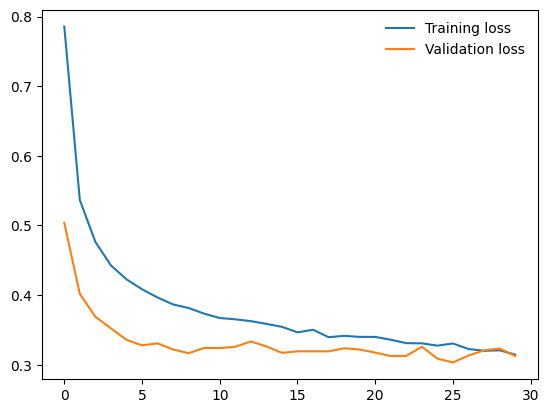

In [7]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)